# Relative Elevation Model: Paraguay River


# Step 0: Setup

### Imports

In [1]:
#!pip install osmnx scipi xarray rioxarray matplotlib datashader -q

In [2]:
#pip install xarray-spatial -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
#pip install geojson

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pathlib import Path
from IPython.core.display import Video

import numpy as np
import pandas as pd
import geopandas as gpd  # Vector data handling
import osmnx as ox       # Downloading data from OSM
import geojson

from shapely.geometry import box
from scipy.spatial import cKDTree as KDTree # For Inverse Distance Weight calculation

import xarray as xr    
import xrspatial    # Hillshading
import rioxarray    # Working with geospatial data in xarray

import matplotlib.pyplot as plt
from datashader.transfer_functions import shade, stack

## Step 1: Download & Load DEM

- [USGS LidarExplorer](https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html#/)

#### **VIDEO**: How to download data from NLS

The downloaded data can be combined using the convenience function[`combine_by_coords`](https://xarray.pydata.org/en/stable/generated/xarray.combine_by_coords.html#xarray.combine_by_coords).

In [149]:
dem = rioxarray.open_rasterio('merged2.tif')

Make DEM smaller and clip to focus area

In [151]:
geom = '''{"type": "Polygon",
                "coordinates":[[[-58.6370207926,-26.898097175],
                [-57.8326155802,-26.898097175],
                [-57.8326155802,-25.8646903186],
                [-58.6370207926,-25.8646903186],
                [-58.6370207926,-26.898097175]]]}'''

In [152]:
cropping_geometries = [geojson.loads(geom)]
cropped = dem.rio.clip(geometries=cropping_geometries, crs=4326)

In [153]:
cropped = cropped.coarsen(x=3, boundary='trim').mean().coarsen(y=3, boundary='trim').mean()

Let's plot the DEM

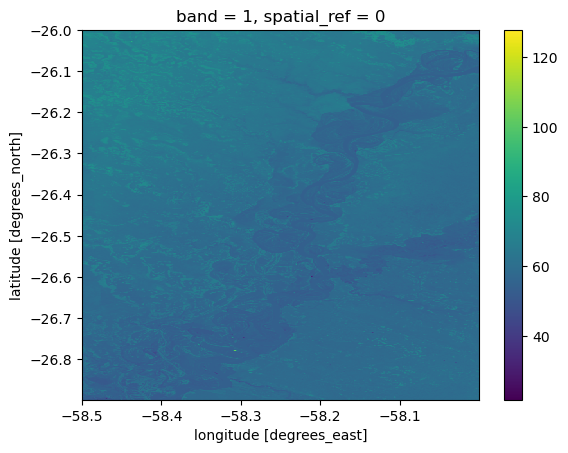

In [154]:
cropped.squeeze().plot.imshow()

## Step 2: Fetch coordinates of the river

In [155]:
river = ox.geocode_to_gdf('R302330', which_result=1, by_osmid=True)
river = river.to_crs(cropped.rio.crs)

Let's plot the river

<Axes: >

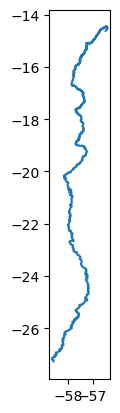

In [156]:
river.plot()

## Step 3: Cut to area of interest

#### River

In [157]:
cropped.rio.bounds()

(-58.49974943541488,
 -26.897888998176235,
 -58.00064546375539,
 -26.000202534585284)

In [158]:
bounds = cropped.rio.bounds()
xmin, ymin, xmax, ymax = bounds

In [159]:
river = river.clip(bounds)

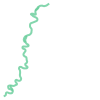

In [160]:
river_geom = river.geometry.iloc[0]
river_geom

#### DEM

In [161]:
cropped = cropped.sel(y=slice(ymax, ymin), x=slice(xmin, xmax))

Let's check if everything looks good

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

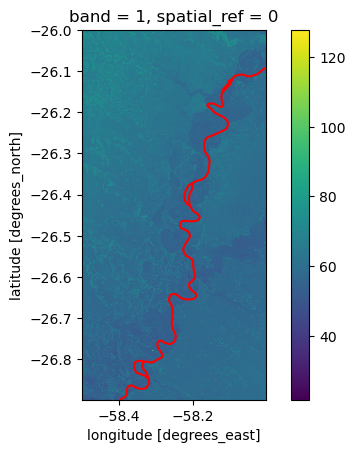

In [162]:
fig, ax = plt.subplots()
cropped.squeeze().plot.imshow(ax=ax)
river.plot(ax=ax, color='red')

## Step 4: Calculate REM

To calculate the REM, we need to 
1. Sample the elevation along the river
2. Interpolate the sampled elevation values to create a 2D elevation raster
3. Subtract the interpolated elevation raster from the DEM

### 4.1. Sample

Extract coordinates as `DataArray`

In [163]:
import shapely

def split_coords(geom):
    x = []
    y = []
    for i in shapely.get_coordinates(geom):
        x.append(i[0])
        y.append(i[1])
    return x, y
        

In [164]:
xs, ys = split_coords(river_geom)
xs, ys = xr.DataArray(xs, dims='z'), xr.DataArray(ys, dims='z')

Use xarray's [`interp`](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.interp.html#xarray.DataArray.interp) to extract the river's elevation.

In [165]:
sampled = cropped.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

### 4.2. Interpolate

Prepare data for the interpolation

In [166]:
# Sampled river coordinates
c_sampled = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T

# All (x, y) coordinates of the original DEM
c_x, c_y = [cropped.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# Sampled values
values = sampled.values.ravel()

In [167]:
c_interpolate

array([[-58.49961469, -26.00033728],
       [-58.4988062 , -26.00033728],
       [-58.49799772, -26.00033728],
       ...,
       [-58.00239718, -26.89775425],
       [-58.00158869, -26.89775425],
       [-58.00078021, -26.89775425]])

Perform the interpolation. Here we use a simple implementation of [IWD](https://en.wikipedia.org/wiki/Inverse_distance_weighting) which averages the 5 nearest points, weighted by inverse distance.

## tree

In [168]:
tree = KDTree(c_sampled)

In [180]:
# IWD interpolation
distances, indices = tree.query(c_interpolate, k=50)

weights = 1 / distances
weights = weights / weights.sum(axis=1).reshape(-1, 1)

interpolated_values = (weights * values[indices]).sum(axis=1)

In [181]:
interpolated_values

array([54.12993691, 54.12993363, 54.12993031, ..., 54.32062545,
       54.32061927, 54.31848793])

We create a `DataArray` out of the inerpolated values

In [182]:
elevation_raster = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

<Axes: xlabel='x', ylabel='y'>

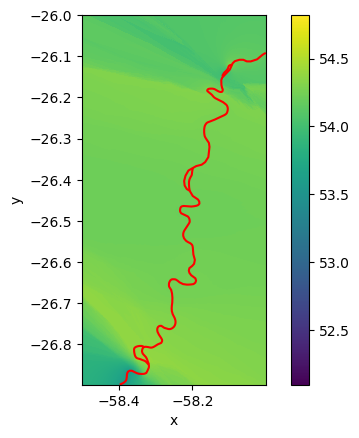

In [183]:
fig, ax = plt.subplots()
elevation_raster.transpose().plot.imshow(ax=ax)
river.plot(ax=ax, color='red')

### 4.3. Calculate

In [184]:
rem = cropped - elevation_raster

# Step 5: Visualize

Let's make some pretty REM visualizations!

In [208]:
colors = ['#211c18', '#a43007','#a5360a','#ec5c0e']

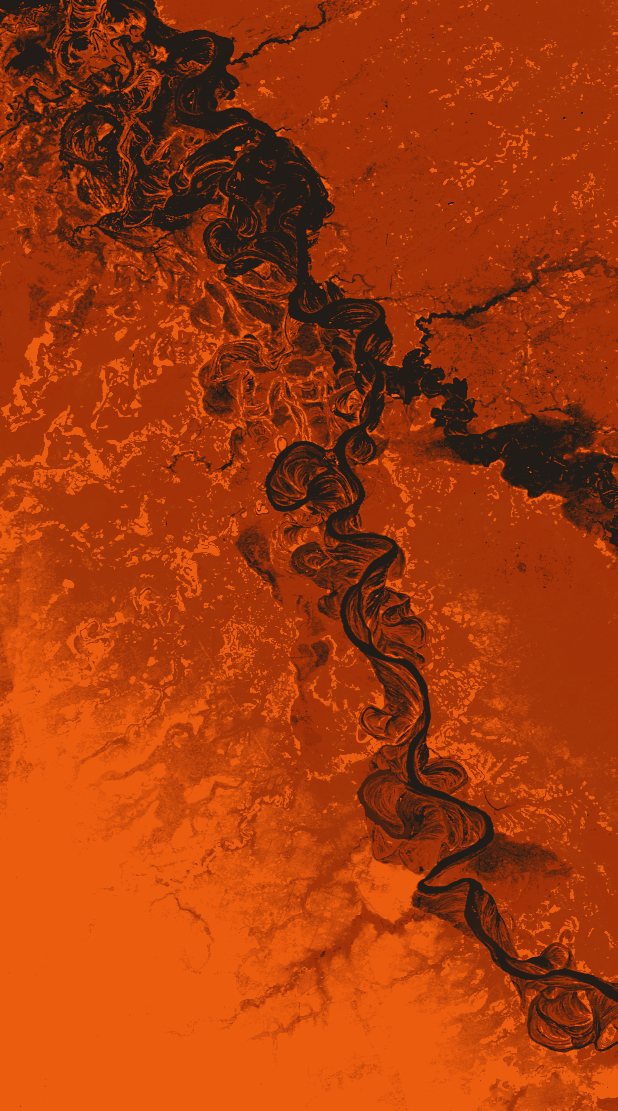

In [211]:
shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear')

We can also visualize the DEM along with the REM

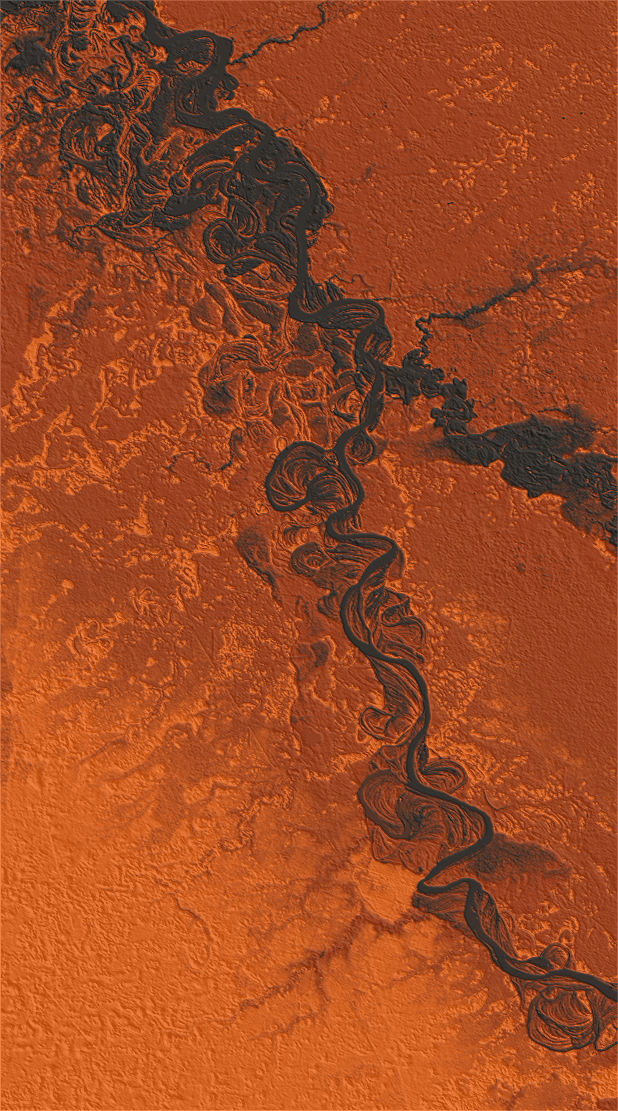

In [212]:
a = shade(xrspatial.hillshade(cropped.squeeze(), angle_altitude=1, azimuth=310), cmap=['black', 'white'], how='linear')
b = shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear', alpha=200)
stack(a, b)


## Method 2 - Remmaker

In [224]:
#!pip install riverrem

In [ ]:
from riverrem.REMMaker import REMMaker

In [231]:
# provide the DEM file path and desired output directory
rem_maker = REMMaker(dem='merged2.tif', out_dir='.')
# create an REM
rem_maker.make_rem()
# create an REM visualization with the given colormap
rem_maker.make_rem_viz(cmap='Reds',z=10)

[INFO] 2023-05-23 21:31:17,392 - Getting DEM projection.
[INFO] 2023-05-23 21:31:17,395 - Reading DEM as array.
[INFO] 2023-05-23 21:31:17,418 - Getting DEM bounds.
[INFO] 2023-05-23 21:31:17,419 - Mapping array indices to coordinates.
[INFO] 2023-05-23 21:31:17,420 - Finding river centerline.
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.

/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/shapely

[INFO] 2023-05-23 21:31:18,025 - 
River lengths:
/Users/thomasartopoulos/anaconda3/lib/python3.10/site-packages/riverrem/REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-05-23 21:31:18,041 - 	Arroyo Ramírez: 0.2807 degree
[INFO] 2023-05-23 21:31:18,048 - 	Arroyo González: 0.2101 degree
[INFO] 2023-05-23 21:31:18,054 - 	Riacho Salado: 0.1250 degree
[INFO] 2023-05-23 21:31:18,062 - 	Riacho San Hilario: 0.8924 degree
[INFO] 2023-05-23 21:31:18,068 - 	Arroyo El Pucú: 0.1285 degree
[INFO] 2023-05-23 21:31:18,074 - 	Riacho Pilagá: 0.4568 degree
[INFO] 2023-05-23 21:31:18,081 - 	Riacho Formosa: 0.5956 degree
[INFO] 2023-05-23 21:31:18,087 - 	Riacho Payagua-í: 0.0485 degree
[INFO] 2023-05-23 21:31:18,093 - 	Saladillo: 0.1143 degree
[INFO] 2023-05-23 21:31:18,100 - 	Río Paraguay: 1.8042 deg


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/merged2_hillshade.tif.

Making color relief map with cmap=Reds.
Tiling and compressing raster.
Saved ./.cache/merged2_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/merged2_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved ./merged2_hillshade-color.tif.

Generating .png file.
Saved ./merged2_hillshade-color.png.


'./merged2_hillshade-color.tif'